In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [19]:
pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 47kB/s 
     |████████████████████████████████| 3.8MB 27.4MB/s 
     |████████████████████████████████| 450kB 34.7MB/s 
     |████████████████████████████████| 51kB 4.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=5e1b9be80cef7d31b16a3f82a99595b370449fc28570fa340ba3086f19a432c6
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tenso

In [20]:
pip show tensorflow

Name: tensorflow
Version: 2.0.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: keras-preprocessing, keras-applications, opt-einsum, six, gast, tensorboard, absl-py, termcolor, wheel, numpy, tensorflow-estimator, google-pasta, wrapt, grpcio, astor, protobuf
Required-by: fancyimpute


In [21]:
import tensorflow as tf
import datetime

In [22]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [5]:
import os
count=0;
import cv2

In [ ]:
# for name in range(1,6):
  # for filename in os.listdir('drive/My Drive/CMP-258 Project/dataset/Test/):
vidObj = cv2.VideoCapture('drive/My Drive/CMP-258 Project/dataset/Test/fi01.avi') 
while True: 
  success, image = vidObj.read() 
  #print(success)
  # Saves the frames with frame-count 
  if (success and count < 200):
    cv2.resize(image,(240,240));
    cv2.imwrite("drive/My Drive/CMP-258 Project/dataset/TestDatasetFrames/frame%d.jpg" % count, image) 
    count += 1
  else:
    break
vidObj.release() 
cv2.destroyAllWindows() 

In [ ]:
count

200

In [ ]:
count=0

In [ ]:
for name in range(1,6):
  for filename in os.listdir('drive/My Drive/CMP-258 Project/dataset/movies/'+str(name)+'/NonViolence'):
    # print(filename)
    vidObj = cv2.VideoCapture('drive/My Drive/CMP-258 Project/dataset/movies/'+str(name)+'/NonViolence/'+filename) 
    while True: 
          success, image = vidObj.read() 
          #print(success)
          # Saves the frames with frame-count 
          if (success and count < 200):
            cv2.resize(image,(240,240));
            cv2.imwrite("drive/My Drive/CMP-258 Project/dataset/TestDatasetFrames/NoFight/frame%d.jpg" % count, image) 
            count += 1
          else:
            break
    vidObj.release() 
    cv2.destroyAllWindows() 

In [6]:
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
#from data import DataSet
import os.path

In [23]:
def get_model(weights='imagenet'):
    # base pre-trained model
    base_model = InceptionV3(weights=weights, include_top=False)

    # global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # output layer
    outputLayer = Dense(2, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputLayer)
    return model

In [8]:
def get_generators():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        horizontal_flip=True,
        rotation_range=10.,
        width_shift_range=0.2,
        height_shift_range=0.2)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        'drive/My Drive/CMP-258 Project/dataset/DatasetFrames',
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')

    return train_generator 
    # ,validation_generator

In [9]:
model = get_model()
generators = get_generators()

87916544/87910968 [==============================] - 1s 0us/step
Found 31618 images belonging to 2 classes.


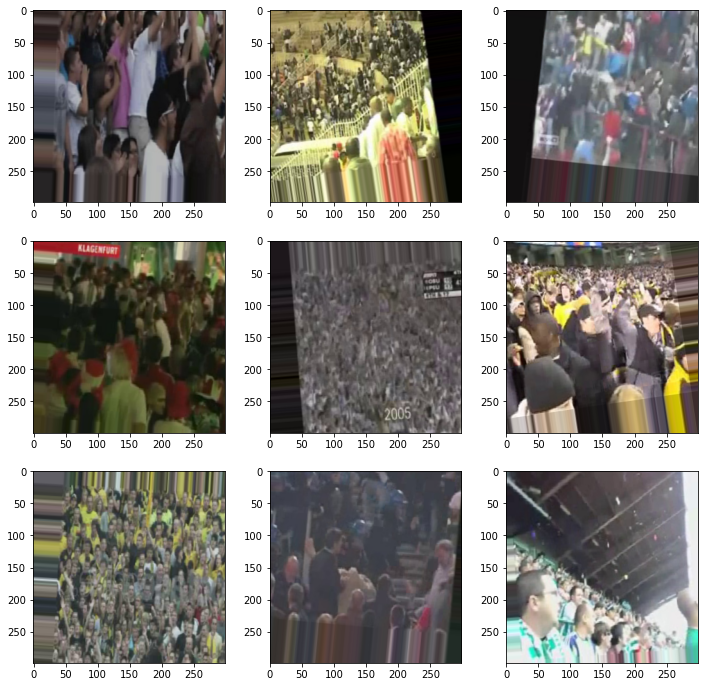

In [10]:
import matplotlib.pyplot as plt
x,y = generators.next()
for i in range(0, 9):
  image = x[i]
  plt.subplot(330 + 1 + i)
  plt.gcf().set_size_inches(12, 12)
  plt.imshow(image)
plt.show()

In [11]:
checkpointer = ModelCheckpoint(
    filepath=os.path.join('data', 'checkpoints', 'inception.{epoch:03d}.hdf5'),
    verbose=1,
    save_best_only=True)

# Helper: Stop when we stop learning.
early_stopper = EarlyStopping(patience=10)

# Helper: TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir= log_dir, histogram_freq=1)
callbacks_list = [checkpointer, tensorboard_callback]

In [24]:
def train_model(model, nb_epoch, generators, callbacks=[]):
    train_generator = generators
    print(train_generator)
    model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=nb_epoch,
        callbacks=callbacks)
    return model

In [25]:
def freeze_all_but_top(model):
    """Used to train just the top layers of the model."""
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in model.layers[:-2]:
        layer.trainable = False

    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def freeze_all_but_mid_and_top(model):
    """After we fine-tune the dense layers, train deeper."""
    # we chose to train the top 2 inception blocks, i.e. we will freeze
    # the first 172 layers and unfreeze the rest:
    for layer in model.layers[:172]:
        layer.trainable = False
    for layer in model.layers[172:]:
        layer.trainable = True

    # we need to recompile the model for these modifications to take effect
    # we use SGD with a low learning rate
    model.compile(
        optimizer=SGD(lr=0.0001, momentum=0.9),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'top_k_categorical_accuracy'])

    return model

In [ ]:
model = freeze_all_but_top(model)
model = train_model(model, 2, generators, [checkpointer, early_stopper, tensorboard_callback])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
100/100 [==============================] - 1111s 11s/step - loss: 2.5387 - accuracy: 0.6755
Epoch 2/2
100/100 [==============================] - 1062s 11s/step - loss: 0.4053 - accuracy: 0.8249


In [26]:
model = freeze_all_but_mid_and_top(model)
model = train_model(model, 1, generators, [checkpointer, early_stopper, tensorboard_callback])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


100/100 [==============================] - 1359s 13s/step - loss: 0.5302 - accuracy: 0.7786 - top_k_categorical_accuracy: 1.0000


In [27]:
model.save('inception_model.h5')

In [28]:
!mkdir -p saved_model
model.save('saved_model/inception_model') 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function canonicalize_signatures.<locals>.signature_wrapper at 0x7f3c0e980950>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function canonicalize_signatures.<locals>.signature_wrapper at 0x7f3c0e980950>. Note tha

In [ ]:
new_model = tf.keras.models.load_model('saved_model/inception_model')

In [ ]:
!zip -r /content/saved_model.zip /content/saved_model

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/my_model/ (stored 0%)
  adding: content/saved_model/my_model/assets/ (stored 0%)
  adding: content/saved_model/my_model/saved_model.pb (deflated 93%)
  adding: content/saved_model/my_model/variables/ (stored 0%)
  adding: content/saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/saved_model/my_model/variables/variables.index (deflated 79%)


In [ ]:
from google.colab import files
files.download("/content/saved_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
!tensorboard dev upload --logdir ./logs \
  --name "Violence Detection" \
  --description "Training results from https://colab.research.google.com/drive/14qzN4f6wmfC4oofuL23oiBT-eIeuHzhY#scrollTo=ds8M0VDKsR3h"

In [ ]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['loss'])

In [ ]:
  plt.plot(model.history.history['accuracy'])

In [ ]:
vidObj = cv2.VideoCapture('drive/My Drive/CMP-258 Project/dataset/Test/nofi01.avi') 
total_fight = 0
total_no_fight = 0
total = 0
while True: 
        success, image = vidObj.read() 
        # Saves the frames with frame-count 
        if success:
          cv2.resize(image,(299,299))
          x = np.expand_dims(image, axis=0)
          images = np.vstack([x])
          classes = new_model.predict(images, batch_size=10)
          if classes[0][0]>0.5:
            total_fight += 1
          else:
            total_no_fight += 1
          total += 1
        else:
          break
vidObj.release() 
cv2.destroyAllWindows() 
if total_fight > total_no_fight:
  print("Fight")
else:
  print("No Fight")

Fight
